In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter # to find most common label

In [ ]:
#Read data
def load_dataset(file_path, dtype=int):
    return np.genfromtxt(file_path, delimiter=" ", dtype=dtype, comments ="!!!!!!!!") #to read words start with hashtag
# Load datasets
train = load_dataset(r"Text Categorization with Decision Trees\trainData.txt")
train_label = load_dataset(r"Text Categorization with Decision TreestrainLabel.txt")
test = load_dataset(r"Text Categorization with Decision Trees\testData.txt")
test_label = load_dataset(r"Text Categorization with Decision Trees\testLabel.txt")
words = load_dataset(r"Text Categorization with Decision Trees\words.txt", dtype=str)

In [ ]:
#convert data to dictionary
def create_dict(data):
    doc_word_dict = {}
    for row in data:
        doc_id, word_id = row[0], row[1]

        if doc_id not in doc_word_dict:
            doc_word_dict[doc_id] = [word_id]
        else:
            doc_word_dict[doc_id].append(word_id)

    return doc_word_dict

def create_labeldic(labels):
    label_dict = {}
    for idx, label in enumerate(labels, start=1):
        label_dict[idx] = [label]
    return label_dict

def convert_to_dict(word_list):
    word_dict = {i + 1: word for i, word in enumerate(word_list)}
    return word_dict


train = create_dict(train)
test = create_dict(test)

train_label = create_labeldic(train_label)
test_label = create_labeldic(test_label)

words = convert_to_dict(words)

In [ ]:
#estimate label of each node (most common label)
def estimate_labels(train, label):
    key_labels = [label[key][0] for key in train.keys()]
    most_common_label = Counter(key_labels).most_common(1)[0][0]

    if most_common_label == 1:
        return 1
    else:
        return 2

In [ ]:
#Entropy and information gain (weighted/ unweighted)
def Entropy(data, label):
    N = len(data)
    if N > 0:
        n1 = sum(label[doc_id][0] == 1 for doc_id in data)
        n2 = sum(label[doc_id][0] == 2 for doc_id in data)
        P_n1 = n1 / N * np.log2(n1 / N) if n1 > 0 else 0
        P_n2 = n2 / N * np.log2(n2 / N) if n2 > 0 else 0
        E_child = -P_n1 - P_n2
    else:
        E_child = 0
    return E_child, N

def info_gain(data, label, wid, E_parent):
    total_yy = [doc_id for doc_id, word_ids in data.items() if wid in word_ids]
    E_child_y, N_y = Entropy(total_yy, label)

    total_nn = [doc_id for doc_id, word_ids in data.items() if wid not in word_ids]
    E_child_n, N_n = Entropy(total_nn, label)

    total_docs = len(data)
    weighted_E_child = (N_y / total_docs) * E_child_y + (N_n / total_docs) * E_child_n

    IG = E_parent - weighted_E_child
    return IG, E_child_y, E_child_n

def info_gain_ave(data, label, wid, E_parent):
    total_yy = [doc_id for doc_id, word_ids in data.items() if wid in word_ids]
    E_child_y, N_y = Entropy(total_yy, label)

    total_nn = [doc_id for doc_id, word_ids in data.items() if wid not in word_ids]
    E_child_n, N_n = Entropy(total_nn, label)

    total_docs = len(data)
    weighted_E_child = 0.5 * E_child_y + 0.5 * E_child_n

    IG = E_parent - weighted_E_child
    return IG, E_child_y, E_child_n

In [ ]:
#
def build_tree(prior_q, data, split_point, label, p_y, p_n):
    #splitted.append(split_point)

    train_y = {key: values for key, values in data.items() if split_point in values}
    train_n = {key: values for key, values in data.items() if split_point not in values}
    word_y = {value for values in data.values() for value in values if value != split_point and split_point in values}
    word_n = {value for values in data.values() for value in values if split_point not in values}


    BS_y=[]
    for i in word_y:
        IG_y, e_y1, e_n1 = info_gain(train_y, label, i, E_parent = p_y)
        BS_y.append((IG_y, i, e_y1, e_n1,"y", split_point))


    #prior_q.pop(0)

    if BS_y != []:
        best_y = max(BS_y, key=lambda x: x[0])
        prior_q.append(best_y + (train_y,))

    else:
        best_y = (float('-inf'), None, None, None, None,None, None)



    BS_n=[]
    for i in word_n:
        IG_n, e_y2, e_n2 = info_gain(train_n, label, i, E_parent = p_n)
        BS_n.append((IG_n, i, e_y2, e_n2, "n", split_point))

    if BS_n != []:
        best_n = max(BS_n, key=lambda x: x[0])
        prior_q.append(best_n + (train_n,))
    else:
        best_n = (float('-inf'), None, None, None, None, None, None)

    prior_q.pop(0) #remove the best node after finding best word

    #prior_q[0][0] == IG , prior_q[0][4] == yes(1)/no(2), prior_q[0][5] == parents
    prior_q = sorted(prior_q, key=lambda x: x[0], reverse=True) # sort them based on info_gain


    train, best_word, E_y, E_n , parents = prior_q[0][6] , prior_q[0][1], prior_q[0][2], prior_q[0][3], prior_q[0][5]

    return prior_q, train, best_word, E_y, E_n, prior_q[0][5]


In [ ]:
#find the first best split (checking)
split_list = []
for i in range(len(words)):
    IG, E_y, E_n = info_gain(train, train_label, i, E_parent=1)  # E_parent = 1 in 1st step, because #1 = #2
    split_list.append((IG, i, E_y, E_n))
best_split = sorted(split_list, key=lambda x: x[0], reverse=True) ##best word!== 1135
IG = best_split[0][0]
best_word = best_split[0][1]
E_y = best_split[0][2]
E_n = best_split[0][3]
best_word #1135
#E_y, E_n #0.3197133690841516, 0.9922666387194963
#IG  #0.07913456456370815

1135

In [ ]:
prior_q = [(0.07913456456370815,1135)]
best_word = 1135
E_y, E_n = 0.3197133690841516, 0.9922666387194963
n_split = 2
output = []

while n_split < 100:

    prior_q , train, best_word, E_y, E_n , parents = build_tree(prior_q, train, best_word, train_label, E_y, E_n )
    est = estimate_labels(train, train_label)
    print(n_split, best_word, prior_q[0][0], prior_q[0][4], est, parents)
    # parents , y/n , child,  child_label
    output.append((parents, prior_q[0][4], best_word, est))
    #print(prior_q)
    n_split += 1
extra_list = prior_q
#output
#internal node

#priority q for weighted:

#index, node, info_gain,         branch, estimated_label, parents
#  1    1135 0.07913456456370815  none         2           none

2 5983 0.1153579525217801 y 2 1135
3 197 0.06945862991358606 n 2 5983
4 2124 0.08422407621310757 n 2 197
5 2437 0.06203372762364212 n 1 1135
6 1228 0.0976949604997708 y 2 2437
7 1038 0.9182958340544896 y 1 1228
8 5369 0.09694460606247315 n 2 1228
9 292 0.058758157105190834 n 2 2124
10 5240 0.036629244599843847 n 1 2437
11 4896 0.11467550533614673 y 1 5240
12 856 0.030284160040603414 n 1 5240
13 6362 0.1366965025593047 y 1 856
14 1063 0.20307392998664564 n 1 6362
15 2138 0.02521603248610138 n 1 856
16 4212 0.12021698233205197 y 2 2138
17 955 0.1006739662916264 n 2 4212
18 2099 0.15217590304145578 n 2 955
19 5048 0.5900048960119098 y 2 2099
20 3590 0.7219280948873623 y 1 5048
21 2337 0.3227569588973982 n 2 2099
22 193 0.02029955143895812 n 1 2138
23 199 0.017414991112225886 n 1 193
24 2158 0.228538143953528 y 1 199
25 4662 0.017312457860162445 n 1 199
26 4829 0.01593521954574173 n 1 4662
27 5020 0.015336931801050113 n 1 4829
28 6383 0.012184061762506193 n 1 5020
29 3163 0.011257595605166

In [ ]:
# leaf nodes (those that are available in priority q but never choose)
extra = []
for i in range(len(extra_list)):
    label_extra = estimate_labels(extra_list[i][6], train_label)
    #parents , y/n , child,  child_label
    extra.append((extra_list[i][5], extra_list[i][4], extra_list[i][1], label_extra))
#extra

In [ ]:
#load train data again!!!
L_estimate = {}
for docid, words in train.items():
    w = 1135  # Start with the root word
    br = 'y' if w in words else 'n'  # Check if the word is in the current document
    L = None  # Initialize label
#####
    for i in output:
        if i[0] == w and i[1] == br:
            w = i[2]  # Get the child node
            br = 'y' if w in words else 'n'  # Check if the word is in the current document

    if L is None:
        # If no label was found in output, check the extra for leaves
        for j in extra:
            if j[0] == w and j[1] == br:
                L = j[3]  # Get the label from extra
                break  # No need to look further if a label has been found
######

    if L is not None:
        L_estimate[docid] = [L]
    ## it could not find 16 docs label == most common
    else:
        L_estimate[docid] = [2]



In [ ]:
# Calculate the accuracy only for documents that have an estimated label in L_estimate
accuracy_train = sum(train_label[doc_id][0] == L_estimate[doc_id][0] for doc_id in L_estimate if doc_id in train_label) / len(L_estimate)
accuracy_train

0.8397260273972603

In [ ]:
#load train data again!!!
L_estimate_test = {}
for docid, words in test.items():
    w = 1135  # Start with the root word
    br = 'y' if w in words else 'n'  # Check if the word is in the current document
    L = None  # Initialize label
#####
    for i in output:
        if i[0] == w and i[1] == br:
            w = i[2]  # Get the child node
            br = 'y' if w in words else 'n'  # Check if the word is in the current document

    if L is None:
        # If no label was found in output, check the extra for leaves
        for j in extra:
            if j[0] == w and j[1] == br:
                L = j[3]  # Get the label from extra
                break  # No need to look further if a label has been found
######

        #if i==len(output):
    if L is not None:
        L_estimate_test[docid] = [L]
    ## it could not find 16 docs label == most comen
    else:
        L_estimate_test[docid] = [2]



In [ ]:
accuracy_test = sum(test_label[doc_id][0] == L_estimate_test[doc_id][0] for doc_id in L_estimate_test if doc_id in test_label) / len(L_estimate_test)
accuracy_test

0.6972413793103448

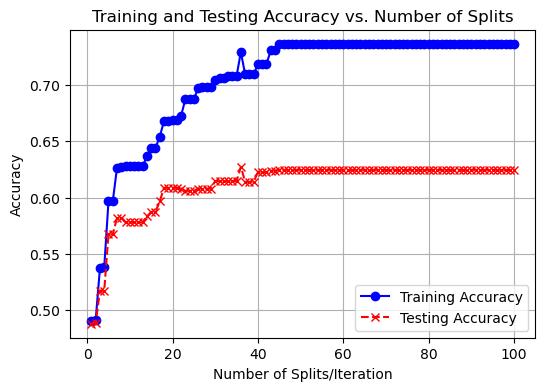

In [ ]:
# Function to estimate labels for a given dataset at a certain depth
def estimate_labels_at_depth(data, output, extra, depth):
    L_estimate = {}
    for docid, words in data.items():
        w = 1135  # Start at the root
        for d in range(depth):
            found = False
            for i in output:
                if i[0] == w and ((i[1] == 'y' and w in words) or (i[1] == 'n' and w not in words)):
                    w = i[2]  # Move to the child node
                    found = True
                    break
            if not found: break  # Stop if no further node is found

        # Check for a leaf node
        for j in extra:
            if j[0] == w and ((j[1] == 'y' and w in words) or (j[1] == 'n' and w not in words)):
                L_estimate[docid] = [j[3]]  # Assign the label from the leaf
                break
        else:
            L_estimate[docid] = [2]  # Assign default label if not found in leaf nodes

    return L_estimate

# Function to calculate accuracy based on estimated labels
def calculate_accuracy(estimated_labels, true_labels):
    correct_predictions = sum(estimated_labels[doc_id][0] == true_labels[doc_id][0] for doc_id in estimated_labels if doc_id in true_labels)

    return correct_predictions / len(true_labels)

# Lists to store accuracies for each depth
accuracies_train = []
accuracies_test = []

# Calculate accuracies for depths from 1 to 100
for depth in range(1, 101):
    estimated_train_labels = estimate_labels_at_depth(train, output, extra, depth)
    estimated_test_labels = estimate_labels_at_depth(test, output, extra, depth)

    accuracy_train = calculate_accuracy(estimated_train_labels, train_label)
    accuracy_test = calculate_accuracy(estimated_test_labels, test_label)

    accuracies_train.append(accuracy_train)
    accuracies_test.append(accuracy_test)

# Plot the training and testing accuracies
plt.figure(figsize=(6, 4))
plt.plot(range(1, 101), accuracies_train, label='Training Accuracy', marker='o', linestyle='-', color='blue')
plt.plot(range(1, 101), accuracies_test, label='Testing Accuracy', marker='x', linestyle='--', color='red')
plt.title('Training and Testing Accuracy vs. Number of Splits')
plt.xlabel('Number of Splits/Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()



**average info gain (unweighted)**

In [ ]:
def build_tree(prior_q, data, split_point, label, p_y, p_n):

    train_y = {key: values for key, values in data.items() if split_point in values}
    train_n = {key: values for key, values in data.items() if split_point not in values}
    word_y = {value for values in data.values() for value in values if value != split_point and split_point in values}
    #word_n = {value for values in data.values() for value in values if value != split_point and split_point not in values}
    word_n = {value for values in data.values() for value in values if split_point not in values}


    BS_y=[]
    for i in word_y:
        IG_y, e_y1, e_n1 = info_gain_ave(train_y, label, i, E_parent = p_y)
        BS_y.append((IG_y, i, e_y1, e_n1,"y", split_point))


    prior_q.pop(0)

    if BS_y != []:
        best_y = max(BS_y, key=lambda x: x[0])
        prior_q.append(best_y + (train_y,))

    else:
        best_y = (float('-inf'), None, None, None, None,None, None)



    BS_n=[]
    for i in word_n:
        IG_n, e_y2, e_n2 = info_gain_ave(train_n, label, i, E_parent = p_n)
        BS_n.append((IG_n, i, e_y2, e_n2, "n", split_point))

    if BS_n != []:
        best_n = max(BS_n, key=lambda x: x[0])
        prior_q.append(best_n + (train_n,))
    else:
        best_n = (float('-inf'), None, None, None, None, None, None)


    #prior_q[0][0] == IG , prior_q[0][4] == yes(1)/no(2), prior_q[0][5] == parents
    prior_q = sorted(prior_q, key=lambda x: x[0], reverse=True)


    train, best_word, E_y, E_n , parents = prior_q[0][6] , prior_q[0][1], prior_q[0][2], prior_q[0][3], prior_q[0][5]

    return prior_q, train, best_word, E_y, E_n, prior_q[0][5]


In [ ]:
split_list = []
for i in range(len(words)):
    IG, E_y, E_n = info_gain_ave(train, train_label, i, E_parent=1)  # Assuming E_parent = 1
    split_list.append((IG, i, E_y, E_n))
best_split = sorted(split_list, key=lambda x: x[0], reverse=True) ##best word!== 1134
best_word = best_split[0][1] ##best word!== 1134y
E_y = best_split[0][2]
E_n = best_split[0][3]

In [ ]:
#parents
prior_q = [(0.5002431851637913, 193)]
best_word = 193
E_y, E_n = -0.0, 0.9995136296724174
n_split = 2
output = []

#total = set()

while n_split <= 100:

    prior_q , train, best_word, E_y, E_n , parents = build_tree(prior_q, train, best_word, train_label, E_y, E_n )
    est = estimate_labels(train, train_label)
    #for item in prior_q:
        # Extracting the second (node), fifth(y/n), and sixth elements(parent) from each tuple
        #total.add((item[5], item[4], item[1]))
        #print(item[1], item[4], item[5])

    #est = estimate_labels(train, train_label)
    print(n_split, best_word, prior_q[0][0], prior_q[0][4], est, parents)
    # parents , y/n , child,  child_label
    output.append((parents, prior_q[0][4], best_word, est))
    #print(prior_q)
    n_split += 1
extra_list = prior_q

2 4662 0.5001975968311954 n 2 193
3 1239 0.49984133000787345 n 2 4662
4 3522 0.49948594834608173 n 2 1239
5 600 0.4986285170876359 n 2 3522
6 4194 0.49806554014941307 n 2 600
7 1148 0.49744479754779886 n 2 4194
8 2383 0.49708778882734583 n 2 1148
9 1417 0.4966383158767908 n 2 2383
10 1552 0.4962826552250311 n 2 1417
11 2992 0.4959056052141205 n 2 1552
12 446 0.49543075623929034 n 2 2992
13 622 0.4950777416692769 n 2 446
14 1010 0.4947086642600939 n 2 622
15 6542 0.4943231697653947 n 2 1010
16 8 0.49383200033628083 n 2 6542
17 84 0.4934949602914547 n 2 8
18 554 0.4931466963049115 n 2 84
19 578 0.49278700846951096 n 2 554
20 1042 0.4924156928103072 n 2 578
21 1483 0.4920325411844787 n 2 1042
22 2482 0.4916373411782741 n 2 1483
23 2742 0.4912298760008649 n 2 2482
24 3617 0.4908099243749965 n 2 2742
25 4773 0.4903772604243183 n 2 3617
26 4886 0.4899316535572734 n 2 4773
27 5532 0.48947286834741877 n 2 4886
28 376 0.48887433428238347 n 2 5532
29 726 0.4885085576037309 n 2 376
30 1684 0.4881

In [ ]:
extra = []
for i in range(len(extra_list)):
    label_extra = estimate_labels(extra_list[i][6], train_label)
    #parents , y/n , child,  child_label
    extra.append((extra_list[i][5], extra_list[i][4], extra_list[i][1], label_extra))

In [ ]:
output #internal node
#parents #branch #node #label

[(193, 'n', 4662, 2),
 (4662, 'n', 1239, 2),
 (1239, 'n', 3522, 2),
 (3522, 'n', 600, 2),
 (600, 'n', 4194, 2),
 (4194, 'n', 1148, 2),
 (1148, 'n', 2383, 2),
 (2383, 'n', 1417, 2),
 (1417, 'n', 1552, 2),
 (1552, 'n', 2992, 2),
 (2992, 'n', 446, 2),
 (446, 'n', 622, 2),
 (622, 'n', 1010, 2),
 (1010, 'n', 6542, 2),
 (6542, 'n', 8, 2),
 (8, 'n', 84, 2),
 (84, 'n', 554, 2),
 (554, 'n', 578, 2),
 (578, 'n', 1042, 2),
 (1042, 'n', 1483, 2),
 (1483, 'n', 2482, 2),
 (2482, 'n', 2742, 2),
 (2742, 'n', 3617, 2),
 (3617, 'n', 4773, 2),
 (4773, 'n', 4886, 2),
 (4886, 'n', 5532, 2),
 (5532, 'n', 376, 2),
 (376, 'n', 726, 2),
 (726, 'n', 1684, 2),
 (1684, 'n', 1934, 2),
 (1934, 'n', 2068, 2),
 (2068, 'n', 2090, 2),
 (2090, 'n', 2100, 2),
 (2100, 'n', 2221, 2),
 (2221, 'n', 2775, 2),
 (2775, 'n', 2815, 2),
 (2815, 'n', 2956, 2),
 (2956, 'n', 3320, 2),
 (3320, 'n', 3506, 2),
 (3506, 'n', 4362, 2),
 (4362, 'n', 4565, 2),
 (4565, 'n', 4686, 2),
 (4686, 'n', 4753, 2),
 (4753, 'n', 5693, 2),
 (5693, 'n', 

In [ ]:
#load train data again!!!
L_estimate = {}
for docid, words in train.items():
    w = 193  # Start with the root word
    br = 'y' if w in words else 'n'  # Check if the word is in the current document
    L = None  # Initialize label
#####
    for i in output:
        if i[0] == w and i[1] == br:
            w = i[2]  # Get the child node
            br = 'y' if w in words else 'n'  # Check if the word is in the current document

    if L is None:
        # If no label was found in output, check the extra for leaves
        for j in extra:
            if j[0] == w and j[1] == br:
                L = j[3]  # Get the label from extra
                break  # No need to look further if a label has been found
######

        #if i==len(output):
    if L is not None:
        L_estimate[docid] = [L]
    ## it could not find 16 docs label == most comen
    else:
        L_estimate[docid] = [2]

# Calculate the accuracy only for documents that have an estimated label in L_estimate
accuracy_train = sum(train_label[doc_id][0] == L_estimate[doc_id][0] for doc_id in L_estimate if doc_id in train_label) / len(L_estimate)
accuracy_train

0.763013698630137

In [ ]:
#load test data again!!!
L_estimate_test = {}
for docid, words in test.items():
    w = 193  # Start with the root word
    br = 'y' if w in words else 'n'  # Check if the word is in the current document
    L = None  # Initialize label
#####
    for i in output:
        if i[0] == w and i[1] == br:
            w = i[2]  # Get the child node
            br = 'y' if w in words else 'n'  # Check if the word is in the current document

    if L is None:
        # If no label was found in output, check the extra for leaves
        for j in extra:
            if j[0] == w and j[1] == br:
                L = j[3]  # Get the label from extra
                break  # No need to look further if a label has been found
######

        #if i==len(output):
    if L is not None:
        L_estimate_test[docid] = [L]
    ## it could not find 16 docs label == most comen
    else:
        L_estimate_test[docid] = [2]

accuracy_test = sum(test_label[doc_id][0] == L_estimate_test[doc_id][0] for doc_id in L_estimate_test if doc_id in test_label) / len(L_estimate_test)
accuracy_test

0.5951724137931035

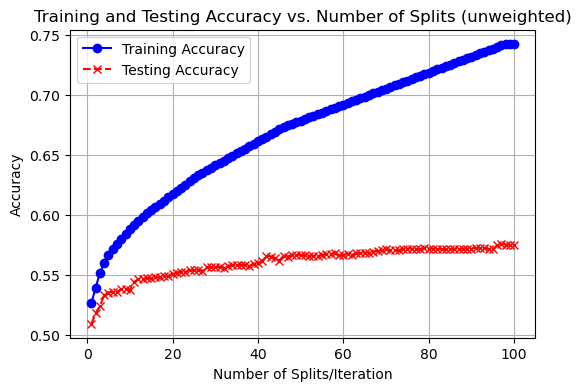

In [ ]:
# Function to estimate labels for a given dataset at a certain depth
def estimate_labels_at_depth(data, output, extra, depth):
    L_estimate = {}
    for docid, words in data.items():
        w = 193  # Start at the root
        for d in range(depth):
            found = False
            for i in output:
                if i[0] == w and ((i[1] == 'y' and w in words) or (i[1] == 'n' and w not in words)):
                    w = i[2]  # Move to the child node
                    found = True
                    break
            if not found: break  # Stop if no further node is found

        # Check for a leaf node
        for j in extra:
            if j[0] == w and ((j[1] == 'y' and w in words) or (j[1] == 'n' and w not in words)):
                L_estimate[docid] = [j[3]]  # Assign the label from the leaf
                break
        else:
            L_estimate[docid] = [2]  # Assign default label if not found in leaf nodes

    return L_estimate

# Function to calculate accuracy based on estimated labels
def calculate_accuracy(estimated_labels, true_labels):
    correct_predictions = sum(estimated_labels[doc_id][0] == true_labels[doc_id][0] for doc_id in estimated_labels if doc_id in true_labels)

    return correct_predictions / len(true_labels)

# Lists to store accuracies for each depth
accuracies_train = []
accuracies_test = []
# Calculate accuracies for depths from 1 to 100
for depth in range(1, 101):
    estimated_train_labels = estimate_labels_at_depth(train, output, extra, depth)
    estimated_test_labels = estimate_labels_at_depth(test, output, extra, depth)

    accuracy_train = calculate_accuracy(estimated_train_labels, train_label)
    accuracy_test = calculate_accuracy(estimated_test_labels, test_label)

    accuracies_train.append(accuracy_train)
    accuracies_test.append(accuracy_test)

# Plot the training and testing accuracies
plt.figure(figsize=(6, 4))
plt.plot(range(1, 101), accuracies_train, label='Training Accuracy', marker='o', linestyle='-', color='blue')
plt.plot(range(1, 101), accuracies_test, label='Testing Accuracy', marker='x', linestyle='--', color='red')
plt.title('Training and Testing Accuracy vs. Number of Splits (unweighted)')
plt.xlabel('Number of Splits/Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()